In [12]:
import tensorflow as tf
from keras import backend as K
import os
import pandas as pd
import cv2 as cv
import numpy as np
import sys
sys.path.insert(0, "../")
from deeparuco.impl.utils import IoU, match_rois
from tensorflow.keras.models import load_model
from ultralytics import YOLO
import matplotlib.pyplot as plt
import csv
import time
import json
from shapely.geometry import Polygon

def calculate_iou(boxA, boxB):    
    polyA = Polygon(boxA)
    polyB = Polygon(boxB)
    
    if not polyA.is_valid or not polyB.is_valid:
        return 0.0
    
    intersection_area = polyA.intersection(polyB).area
    union_area = polyA.union(polyB).area
    
    return intersection_area / union_area if union_area > 0 else 0.0

def is_bbox_in_bounds(bbox_corners, h, w):
    marker_w = bbox_corners[2][0]-bbox_corners[0][0]
    marker_h = bbox_corners[2][1]-bbox_corners[0][1]
    for x, y in bbox_corners:
        if not (-marker_w/14 <= x <= w+marker_w/14 and -marker_h/14 <= y <= h+marker_h/14):
            return False
    return True  

In [15]:
model = YOLO('../models/nested2_detector_n/best.pt')
# model = YOLO('../models/yolotag_model/best.pt')

One image


0: 512x640 1 35, 1 36, 8.7ms
Speed: 14.2ms preprocess, 8.7ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)
test
0.9857423735198995
0.11447145143891302
0.01288469900118005
test
0.9844443363031127
0.11500524624818244
0.012944781976973357


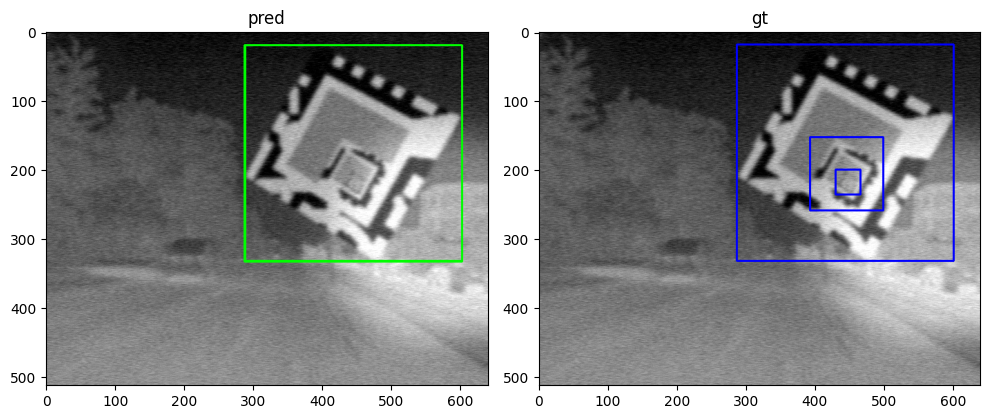

In [18]:
im_path    = '../dataset/nested2/images/test/video-ePoikf5LyTTfqchga-frame-000433-hmHkcDQSQCzqrP8wR.jpg'
label_path = '../dataset/nested2/labels/test/video-ePoikf5LyTTfqchga-frame-000433-hmHkcDQSQCzqrP8wR.json'

with open(label_path, 'r') as l:
    data = json.load(l)

im = cv.imread(im_path)
im_gt = cv.imread(im_path)
h, w = im.shape[:2]

results = model(im)[0]
for result in results.boxes.data.tolist():
    print('test')
    x1, y1, x2, y2, score, class_id = result
    for marker in data:
        pred_bbox = [(x1, y1), (x2, y1), (x2, y2), (x1, y2)]
        bbox = marker['bbox_corners']
        bbox = [(max(0, min(x, w)), max(0, min(y, h))) for x, y in bbox]
        iou = calculate_iou(pred_bbox, bbox)
        print(iou)
    cv.rectangle(im, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

# To display the image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(im)
plt.grid(False)
plt.title('pred')

plt.subplot(1, 2, 2)
for marker in data:
    bbox = marker['bbox_corners']
    bbox = [(int(max(0, min(x, w))), int(max(0, min(y, h)))) for x, y in bbox]
    cv.rectangle(im_gt, bbox[0], bbox[2], (0, 0, 255), 2)
plt.imshow(im_gt)
plt.title('gt')
plt.grid(False)
plt.tight_layout()
plt.show()

In [15]:
im_path    = '../dataset/nested2/images/test/video-ePoikf5LyTTfqchga-frame-000433-hmHkcDQSQCzqrP8wR.jpg'
label_path = '../dataset/nested2/labels/test/video-ePoikf5LyTTfqchga-frame-000433-hmHkcDQSQCzqrP8wR.json'


with open(label_path, 'r') as l:
    data = json.load(l)
im = cv.imread(im_path)
h, w = im.shape[:2]
num_markers = len(data)
IDs = []
bboxes = []
reflections = []
sizes = []
for marker in data:
    IDs.append(marker['tag_id'])
    bbox_ori = marker['bbox_corners']
    marker_w = bbox_ori[2][0]-bbox_ori[0][0]
    marker_h = bbox_ori[2][1]-bbox_ori[0][1]
    if is_bbox_in_bounds(bbox_ori, h, w):
        bbox = [(int(max(0, min(x, w))), int(max(0, min(y, h)))) for x, y in bbox_ori]
        bboxes.append(bbox)
        reflections.append(marker['reflection_area'])
        sizes.append(bbox[2][0]-bbox[0][0])

# Predict bbox
results = model(im)[0]

TPs = 0
FPs = 0
FNs = 0
matched_gt = []
FP_size = []
FP_x1 = []
FP_x2 = []
FP_y1 = []
FP_y2 = []
best_match = None
for result in results.boxes.data.tolist():
    x1, y1, x2, y2, score, class_id = result
    print("class_id")
    print(class_id)
    h, w = im.shape[:2]
    
    pred_bbox = [(x1, y1), (x2, y1), (x2, y2), (x1, y2)]
    best_iou = 0
    best_match = None
    for i, (gt_bbox, id, reflection, size) in enumerate(zip(bboxes, IDs, reflections, sizes)):

        iou = calculate_iou(pred_bbox, gt_bbox)
        if iou > best_iou and iou >= 0.5:
            best_iou = iou
            best_match = id

    if best_match is not None:
        TPs += 1
        matched_gt.append(best_match)
        FP_size.append('NONE')
        FP_x1.append(x1)
        FP_x2.append(x2)
        FP_y1.append(y1)
        FP_y2.append(y2)
    else:
        FPs += 1
        matched_gt.append('NONE')
        FP_size.append(x2-x1)
        FP_x1.append(x1)
        FP_x2.append(x2)
        FP_y1.append(y1)
        FP_y2.append(y2)

FNs = len(bboxes) - len(matched_gt)

for i, matched in enumerate(matched_gt):
    # False positives
    if matched == 'NONE':
        x1 = FP_x1[i]
        x2 = FP_x2[i]
        y1 = FP_y1[i]
        y2 = FP_y2[i]
        marker_name = 'NONE'
        matched_reflection = 'NONE'
        matched_size = FP_size[i]
        print([marker_name, matched, matched_reflection, matched_size, 0, 1, 0])

    # True positives
    elif matched in IDs:
        print(matched)
        idx = IDs.index(matched)
        marker_name = f"{matched}"
        matched_reflection = reflections[idx]
        matched_size = sizes[idx]
        print([marker_name, matched, matched_reflection, matched_size, 1, 0, 0])
        del bboxes[idx]
        del IDs[idx]
        del reflections[idx]
        del sizes[idx]
        
# False negatives
for i, (gt_bbox, id, reflection, size) in enumerate(zip(bboxes, IDs, reflections, sizes)):
    marker_name = f"{id}"
    print([marker_name, id,reflection, size, 0, 0, 1])


0: 512x640 1 35, 1 36, 9.1ms
Speed: 6.2ms preprocess, 9.1ms inference, 2.9ms postprocess per image at shape (1, 3, 512, 640)
class_id
35.0
class_id
36.0
10
['10', 10, 31.40190458141849, 314, 1, 0, 0]
['39', 39, 31.40190458141849, 106, 0, 0, 1]
['45', 45, 31.40190458141849, 36, 0, 0, 1]


Multiple images

In [ ]:
eval_path = '../dataset/nested2/detect_eval_model_n.csv'
im_dir    = '../dataset/nested2/images/test/'
label_dir = "../dataset/nested2/labels/test/"
start_time = time.time()

with open(eval_path, 'a', newline='') as eval_file:
	csv_writer = csv.writer(eval_file)
	csv_writer.writerow(['image', 'id', 'location', 'reflection', 'marker_size', 'size_ratio', 'TP', 'FP', 'FN'])

	for im_name in os.listdir(im_dir):	# Read image and lable
		im_path = im_dir + im_name
		name = im_name.split('.')[0]
		label_path = label_dir + name + '.json'
		with open(label_path, 'r') as l:
			data = json.load(l)
		im = cv.imread(im_path)
		h, w = im.shape[:2]
		im_size = h * w
		num_markers = len(data)
		IDs = []
		bboxes = []
		reflections = []
		sizes = []
		sizes_ratio = []
		locations = ['outer', 'middle', 'inner']
		for marker in data:
			IDs.append(marker['tag_id'])
			bbox_ori = marker['bbox_corners']
			if is_bbox_in_bounds(bbox_ori, h, w):
				bbox = [(int(max(0, min(x, w))), int(max(0, min(y, h)))) for x, y in bbox_ori]
				bboxes.append(bbox)
				reflections.append(marker['reflection_area'])
				sizes.append(bbox[2][0]-bbox[0][0])
				w_bbox = bbox[2][0]-bbox[0][0]
				h_bbox = bbox[2][1]-bbox[0][1]
				bbox_size = w_bbox * h_bbox
				sr = bbox_size / im_size
				sizes_ratio.append(sr)
			else:
				del locations[0]
			
		# Predict bbox
		results = model(im)[0]

		TPs = 0
		FPs = 0
		FNs = 0
		matched_gt = []
		FP_size = []
		FP_x1 = []
		FP_x2 = []
		FP_y1 = []
		FP_y2 = []
		best_match = None
		for result in results.boxes.data.tolist():
			x1, y1, x2, y2, score, class_id = result
			h, w = im.shape[:2]
			
			pred_bbox = [(x1, y1), (x2, y1), (x2, y2), (x1, y2)]
			best_iou = 0
			best_match = None

			for i, (gt_bbox, id, reflection, size) in enumerate(zip(bboxes, IDs, reflections, sizes)):
				iou = calculate_iou(pred_bbox, gt_bbox)
				if iou > best_iou and iou >= 0.5:
					best_iou = iou
					best_match = id
		
			if best_match is not None:
				TPs += 1
				matched_gt.append(best_match)
				FP_size.append('NONE')
				FP_x1.append(x1)
				FP_x2.append(x2)
				FP_y1.append(y1)
				FP_y2.append(y2)
			else:
				FPs += 1
				matched_gt.append('NONE')
				FP_size.append(x2-x1)
				FP_x1.append(x1)
				FP_x2.append(x2)
				FP_y1.append(y1)
				FP_y2.append(y2)
		
		FNs = len(bboxes) - len(matched_gt)
		
		for i, matched in enumerate(matched_gt):
			# False positives
			if matched == 'NONE':
				x1 = FP_x1[i]
				x2 = FP_x2[i]
				y1 = FP_y1[i]
				y2 = FP_y2[i]
				marker_name = name
				matched_reflection = 'NONE'
				matched_location = 'NONE'
				matched_size = FP_size[i]
				csv_writer.writerow([name, matched, matched_location, matched_reflection, matched_size, 0, 0, 1, 0])

			# True positives
			elif matched in IDs:
				# print(IDs)
				# print(matched)
				print(im_name)
				idx = IDs.index(matched)
				marker_name = f"{name}_{matched}"
				matched_reflection = reflections[idx]
				matched_size = sizes[idx]
				matched_location = locations[idx]
				size_ratio = sizes_ratio[idx]
				csv_writer.writerow([name, matched, matched_location, matched_reflection, matched_size, size_ratio, 1, 0, 0])
				del bboxes[idx]
				del IDs[idx]
				del reflections[idx]
				del sizes[idx]
				del locations[idx]
				del sizes_ratio[idx]
				
		# False negatives
		for i, (gt_bbox, id, location, reflection, size, sr) in enumerate(zip(bboxes, IDs, locations, reflections, sizes, sizes_ratio)):
			csv_writer.writerow([name, id, location, reflection, size, sr, 0, 0, 1])
			
				

end_time = time.time()


0: 480x640 2 markers, 11.2ms
Speed: 2.4ms preprocess, 11.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)
06349831cbcb8f2c.jpg
06349831cbcb8f2c.jpg

0: 448x640 2 markers, 10.5ms
Speed: 1.8ms preprocess, 10.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)
1ead457c867be1cd.jpg
1ead457c867be1cd.jpg

0: 512x640 3 markers, 11.6ms
Speed: 1.4ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)
video-4FRnNpmSmwktFJKjg-frame-000746-9CgazXqHXeEATqtKz.jpg
video-4FRnNpmSmwktFJKjg-frame-000746-9CgazXqHXeEATqtKz.jpg
video-4FRnNpmSmwktFJKjg-frame-000746-9CgazXqHXeEATqtKz.jpg

0: 448x640 2 markers, 8.5ms
Speed: 2.1ms preprocess, 8.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)
8af0b106463da353.jpg
8af0b106463da353.jpg

0: 512x640 2 markers, 10.1ms
Speed: 1.6ms preprocess, 10.1ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)
video-ePoikf5LyTTfqchga-frame-000433-hmHkcDQSQCzqrP8wR.jpg
video

This is for YOLOtag

In [14]:
eval_path = '../dataset/nested2/detect_eval_model_yolotag.csv'
im_dir    = '../dataset/nested2/images/test/'
label_dir = "../dataset/nested2/labels/test/"
start_time = time.time()

with open(eval_path, 'a', newline='') as eval_file:
	csv_writer = csv.writer(eval_file)
	csv_writer.writerow(['image', 'id', 'location', 'reflection', 'marker_size', 'size_ratio', 'TP', 'FP', 'FN'])

	for im_name in os.listdir(im_dir):	# Read image and lable
		im_path = im_dir + im_name
		name = im_name.split('.')[0]
		label_path = label_dir + name + '.json'
		with open(label_path, 'r') as l:
			data = json.load(l)
		im = cv.imread(im_path)
		h, w = im.shape[:2]
		im_size = h * w
		num_markers = len(data)
		IDs = []
		bboxes = []
		reflections = []
		sizes = []
		sizes_ratio = []
		locations = ['outer', 'middle', 'inner']
		for marker in data:
			IDs.append(marker['tag_id'])
			bbox_ori = marker['bbox_corners']
			if is_bbox_in_bounds(bbox_ori, h, w):
				bbox = [(int(max(0, min(x, w))), int(max(0, min(y, h)))) for x, y in bbox_ori]
				bboxes.append(bbox)
				reflections.append(marker['reflection_area'])
				sizes.append(bbox[2][0]-bbox[0][0])
				w_bbox = bbox[2][0]-bbox[0][0]
				h_bbox = bbox[2][1]-bbox[0][1]
				bbox_size = w_bbox * h_bbox
				sr = bbox_size / im_size
				sizes_ratio.append(sr)
			else:
				del locations[0]
			
		# Predict bbox
		results = model(im)[0]

		TPs = 0
		FPs = 0
		FNs = 0
		matched_gt = []
		FP_size = []
		FP_x1 = []
		FP_x2 = []
		FP_y1 = []
		FP_y2 = []
		best_match = None
		for result in results.boxes.data.tolist():
			x1, y1, x2, y2, score, class_id = result
			h, w = im.shape[:2]
			
			pred_bbox = [(x1, y1), (x2, y1), (x2, y2), (x1, y2)]
			best_iou = 0
			best_match = None

			for i, (gt_bbox, id, reflection, size) in enumerate(zip(bboxes, IDs, reflections, sizes)):
				iou = calculate_iou(pred_bbox, gt_bbox)
				if iou > best_iou and iou >= 0.5 and int(class_id) == id:
					best_iou = iou
					best_match = id
		
			if best_match is not None:
				TPs += 1
				matched_gt.append(best_match)
				FP_size.append('NONE')
				FP_x1.append(x1)
				FP_x2.append(x2)
				FP_y1.append(y1)
				FP_y2.append(y2)
			else:
				FPs += 1
				matched_gt.append('NONE')
				FP_size.append(x2-x1)
				FP_x1.append(x1)
				FP_x2.append(x2)
				FP_y1.append(y1)
				FP_y2.append(y2)
		
		FNs = len(bboxes) - len(matched_gt)
		
		for i, matched in enumerate(matched_gt):
			# False positives
			if matched == 'NONE':
				x1 = FP_x1[i]
				x2 = FP_x2[i]
				y1 = FP_y1[i]
				y2 = FP_y2[i]
				marker_name = name
				matched_reflection = 'NONE'
				matched_location = 'NONE'
				matched_size = FP_size[i]
				csv_writer.writerow([name, matched, matched_location, matched_reflection, matched_size, 0, 0, 1, 0])

			# True positives
			elif matched in IDs:
				# print(IDs)
				# print(matched)
				print(im_name)
				idx = IDs.index(matched)
				marker_name = f"{name}_{matched}"
				matched_reflection = reflections[idx]
				matched_size = sizes[idx]
				matched_location = locations[idx]
				size_ratio = sizes_ratio[idx]
				csv_writer.writerow([name, matched, matched_location, matched_reflection, matched_size, size_ratio, 1, 0, 0])
				del bboxes[idx]
				del IDs[idx]
				del reflections[idx]
				del sizes[idx]
				del locations[idx]
				del sizes_ratio[idx]
				
		# False negatives
		for i, (gt_bbox, id, location, reflection, size, sr) in enumerate(zip(bboxes, IDs, locations, reflections, sizes, sizes_ratio)):
			csv_writer.writerow([name, id, location, reflection, size, sr, 0, 0, 1])
			
				

end_time = time.time()


0: 480x640 1 26, 33.8ms
Speed: 8.3ms preprocess, 33.8ms inference, 576.8ms postprocess per image at shape (1, 3, 480, 640)
06349831cbcb8f2c.jpg

0: 448x640 1 5, 34.0ms
Speed: 2.2ms preprocess, 34.0ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)
1ead457c867be1cd.jpg

0: 512x640 1 27, 36.2ms
Speed: 1.6ms preprocess, 36.2ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)
video-4FRnNpmSmwktFJKjg-frame-000746-9CgazXqHXeEATqtKz.jpg

0: 448x640 1 27, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)
8af0b106463da353.jpg

0: 512x640 1 35, 1 36, 9.5ms
Speed: 1.4ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 (no detections), 8.7ms
Speed: 1.5ms preprocess, 8.7ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 36, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 

In [6]:
3000 / (end_time - start_time)

42.218567518985196

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

csv_path_model = '../dataset/nested2/detect_eval_model_n.csv'

dfm = pd.read_csv(csv_path_model)

# dfm['marker_size'] = pd.to_numeric(dfm['marker_size'], errors='coerce')
dfm[['marker_size', 'TP', 'FP', 'FN']] = dfm[['marker_size', 'TP', 'FP', 'FN']].apply(pd.to_numeric, errors='coerce')

max_size = dfm['marker_size'].max()

bins = np.arange(0, max_size + 2, 10)
dfm['size_bin'] = pd.cut(dfm['marker_size'], bins=bins, include_lowest=True, right=False)
agg_dfm = dfm.groupby('size_bin').sum().reset_index()
agg_dfm['count'] = agg_dfm['TP'] + agg_dfm['FN']
agg_dfm = agg_dfm.loc[agg_dfm['count'] != 0].reset_index(drop=True)
agg_dfm['TP_frac'] = agg_dfm['TP'] / agg_dfm['count']
agg_dfm['FP_frac'] = agg_dfm['FP'] / agg_dfm['count']
agg_dfm['FN_frac'] = agg_dfm['FN'] / agg_dfm['count']
# agg_dfm['TP_frac'].fillna(0, inplace=True)
# agg_dfm['FP_frac'].fillna(0, inplace=True)
# agg_dfm['FN_frac'].fillna(0, inplace=True)

bin_midpoints = [(interval.left + interval.right) / 2 for interval in agg_dfm['size_bin']]

agg_dfm_TP = list(agg_dfm['TP_frac'])  
agg_dfm_FP = list(agg_dfm['FP'])
agg_dfm_FN = list(agg_dfm['FN_frac'])  

/tmp/ipykernel_8128/3893195339.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_dfm = dfm.groupby('size_bin').sum().reset_index()


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

csv_path_model = '../dataset/nested2/detect_eval_model_yolotag.csv'

dfy = pd.read_csv(csv_path_model)

# dfy['marker_size'] = pd.to_numeric(dfy['marker_size'], errors='coerce')
dfy[['marker_size', 'TP', 'FP', 'FN']] = dfy[['marker_size', 'TP', 'FP', 'FN']].apply(pd.to_numeric, errors='coerce')

max_size = dfy['marker_size'].max()

bins = np.arange(0, max_size + 2, 10)
dfy['size_bin'] = pd.cut(dfy['marker_size'], bins=bins, include_lowest=True, right=False)
agg_dfy = dfy.groupby('size_bin').sum().reset_index()
agg_dfy['count'] = agg_dfy['TP'] + agg_dfy['FN']
agg_dfy = agg_dfy.loc[agg_dfy['count'] != 0].reset_index(drop=True)
agg_dfy['TP_frac'] = agg_dfy['TP'] / agg_dfy['count']
agg_dfy['FP_frac'] = agg_dfy['FP'] / agg_dfy['count']
agg_dfy['FN_frac'] = agg_dfy['FN'] / agg_dfy['count']

bin_midpoints = [(interval.left + interval.right) / 2 for interval in agg_dfy['size_bin']]

agg_dfy_TP = list(agg_dfy['TP_frac'])  
agg_dfy_FP = list(agg_dfy['FP'])
agg_dfy_FN = list(agg_dfy['FN_frac'])  

/tmp/ipykernel_8128/2926147972.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_dfy = dfy.groupby('size_bin').sum().reset_index()


In [30]:
bins_with_FN_frac_1 = agg_dfm.loc[agg_dfm['FN'] == 1, 'size_bin']
filtered_dfm = dfm[dfm['size_bin'].isin(bins_with_FN_frac_1) & (dfm['marker_size'] > 400)]
print(filtered_dfm)

                                                  image    id location  \
54    video-ZAtDSNuZZjkZFvMAo-frame-001280-NwxWvE9da...    25    outer   
63                                  97be0fd4d7d12a18_44    44    outer   
69    video-SCiKdG3MqZfiE292B-frame-007984-WfMuzDaBd...    21    outer   
72    video-ePoikf5LyTTfqchga-frame-000683-nmsjq5TuY...    25    outer   
99                                  fdec7849a0a64567_23    23    outer   
...                                                 ...   ...      ...   
8869  video-ePoikf5LyTTfqchga-frame-000647-ADDR5t8kY...  NONE     NONE   
8887  video-4FRnNpmSmwktFJKjg-frame-000920-zQTGBXAfW...    23    outer   
8895  video-ZAtDSNuZZjkZFvMAo-frame-001393-wxEH5vuQC...     2    outer   
8898                                 078487a2cbd4e706_8     8    outer   
8918  video-SCiKdG3MqZfiE292B-frame-006417-zrMHt2yTw...    44    outer   

              reflection  marker_size  TP  FP  FN        size_bin  
54     24.47170756134201   456.000000   1  

In [31]:
bins_with_FP_frac_1 = agg_dfm.loc[agg_dfm['FP'] == 1, 'size_bin']
filtered_dfm = dfm[dfm['size_bin'].isin(bins_with_FP_frac_1) & (dfm['marker_size'] < 200) ]
print(filtered_dfm)

Empty DataFrame
Columns: [image, id, location, reflection, marker_size, TP, FP, FN, size_bin]
Index: []


In [19]:
total_tpm = dfm['TP'].sum()
total_fpm = dfm['FP'].sum()
total_fnm = dfm['FN'].sum()
precision_m = total_tpm / (total_tpm + total_fpm)
recall_m = total_tpm / (total_tpm + total_fnm)

print(f'Total True Positives (TP): {total_tpm}')
print(f'Total False Positives (FP): {total_fpm}')
print(f'Total False Negatives (FN): {total_fnm}')
print(f'Total precision: {precision_m}')
print(f'Total recall: {recall_m}')

Total True Positives (TP): 5841
Total False Positives (FP): 153
Total False Negatives (FN): 2995
Total precision: 0.9744744744744744
Total recall: 0.6610457220461747


In [20]:
new_dfm = dfm[dfm['marker_size'] > 50]
total_tpm = new_dfm['TP'].sum()
total_fpm = new_dfm['FP'].sum()
total_fnm = new_dfm['FN'].sum()
precision_m = total_tpm / (total_tpm + total_fpm)
recall_m = total_tpm / (total_tpm + total_fnm)

print(f'Total True Positives (TP): {total_tpm}')
print(f'Total False Positives (FP): {total_fpm}')
print(f'Total False Negatives (FN): {total_fnm}')
print(f'Total precision: {precision_m}')
print(f'Total recall: {recall_m}')

Total True Positives (TP): 5696
Total False Positives (FP): 153
Total False Negatives (FN): 119
Total precision: 0.9738416823388614
Total recall: 0.9795356835769562


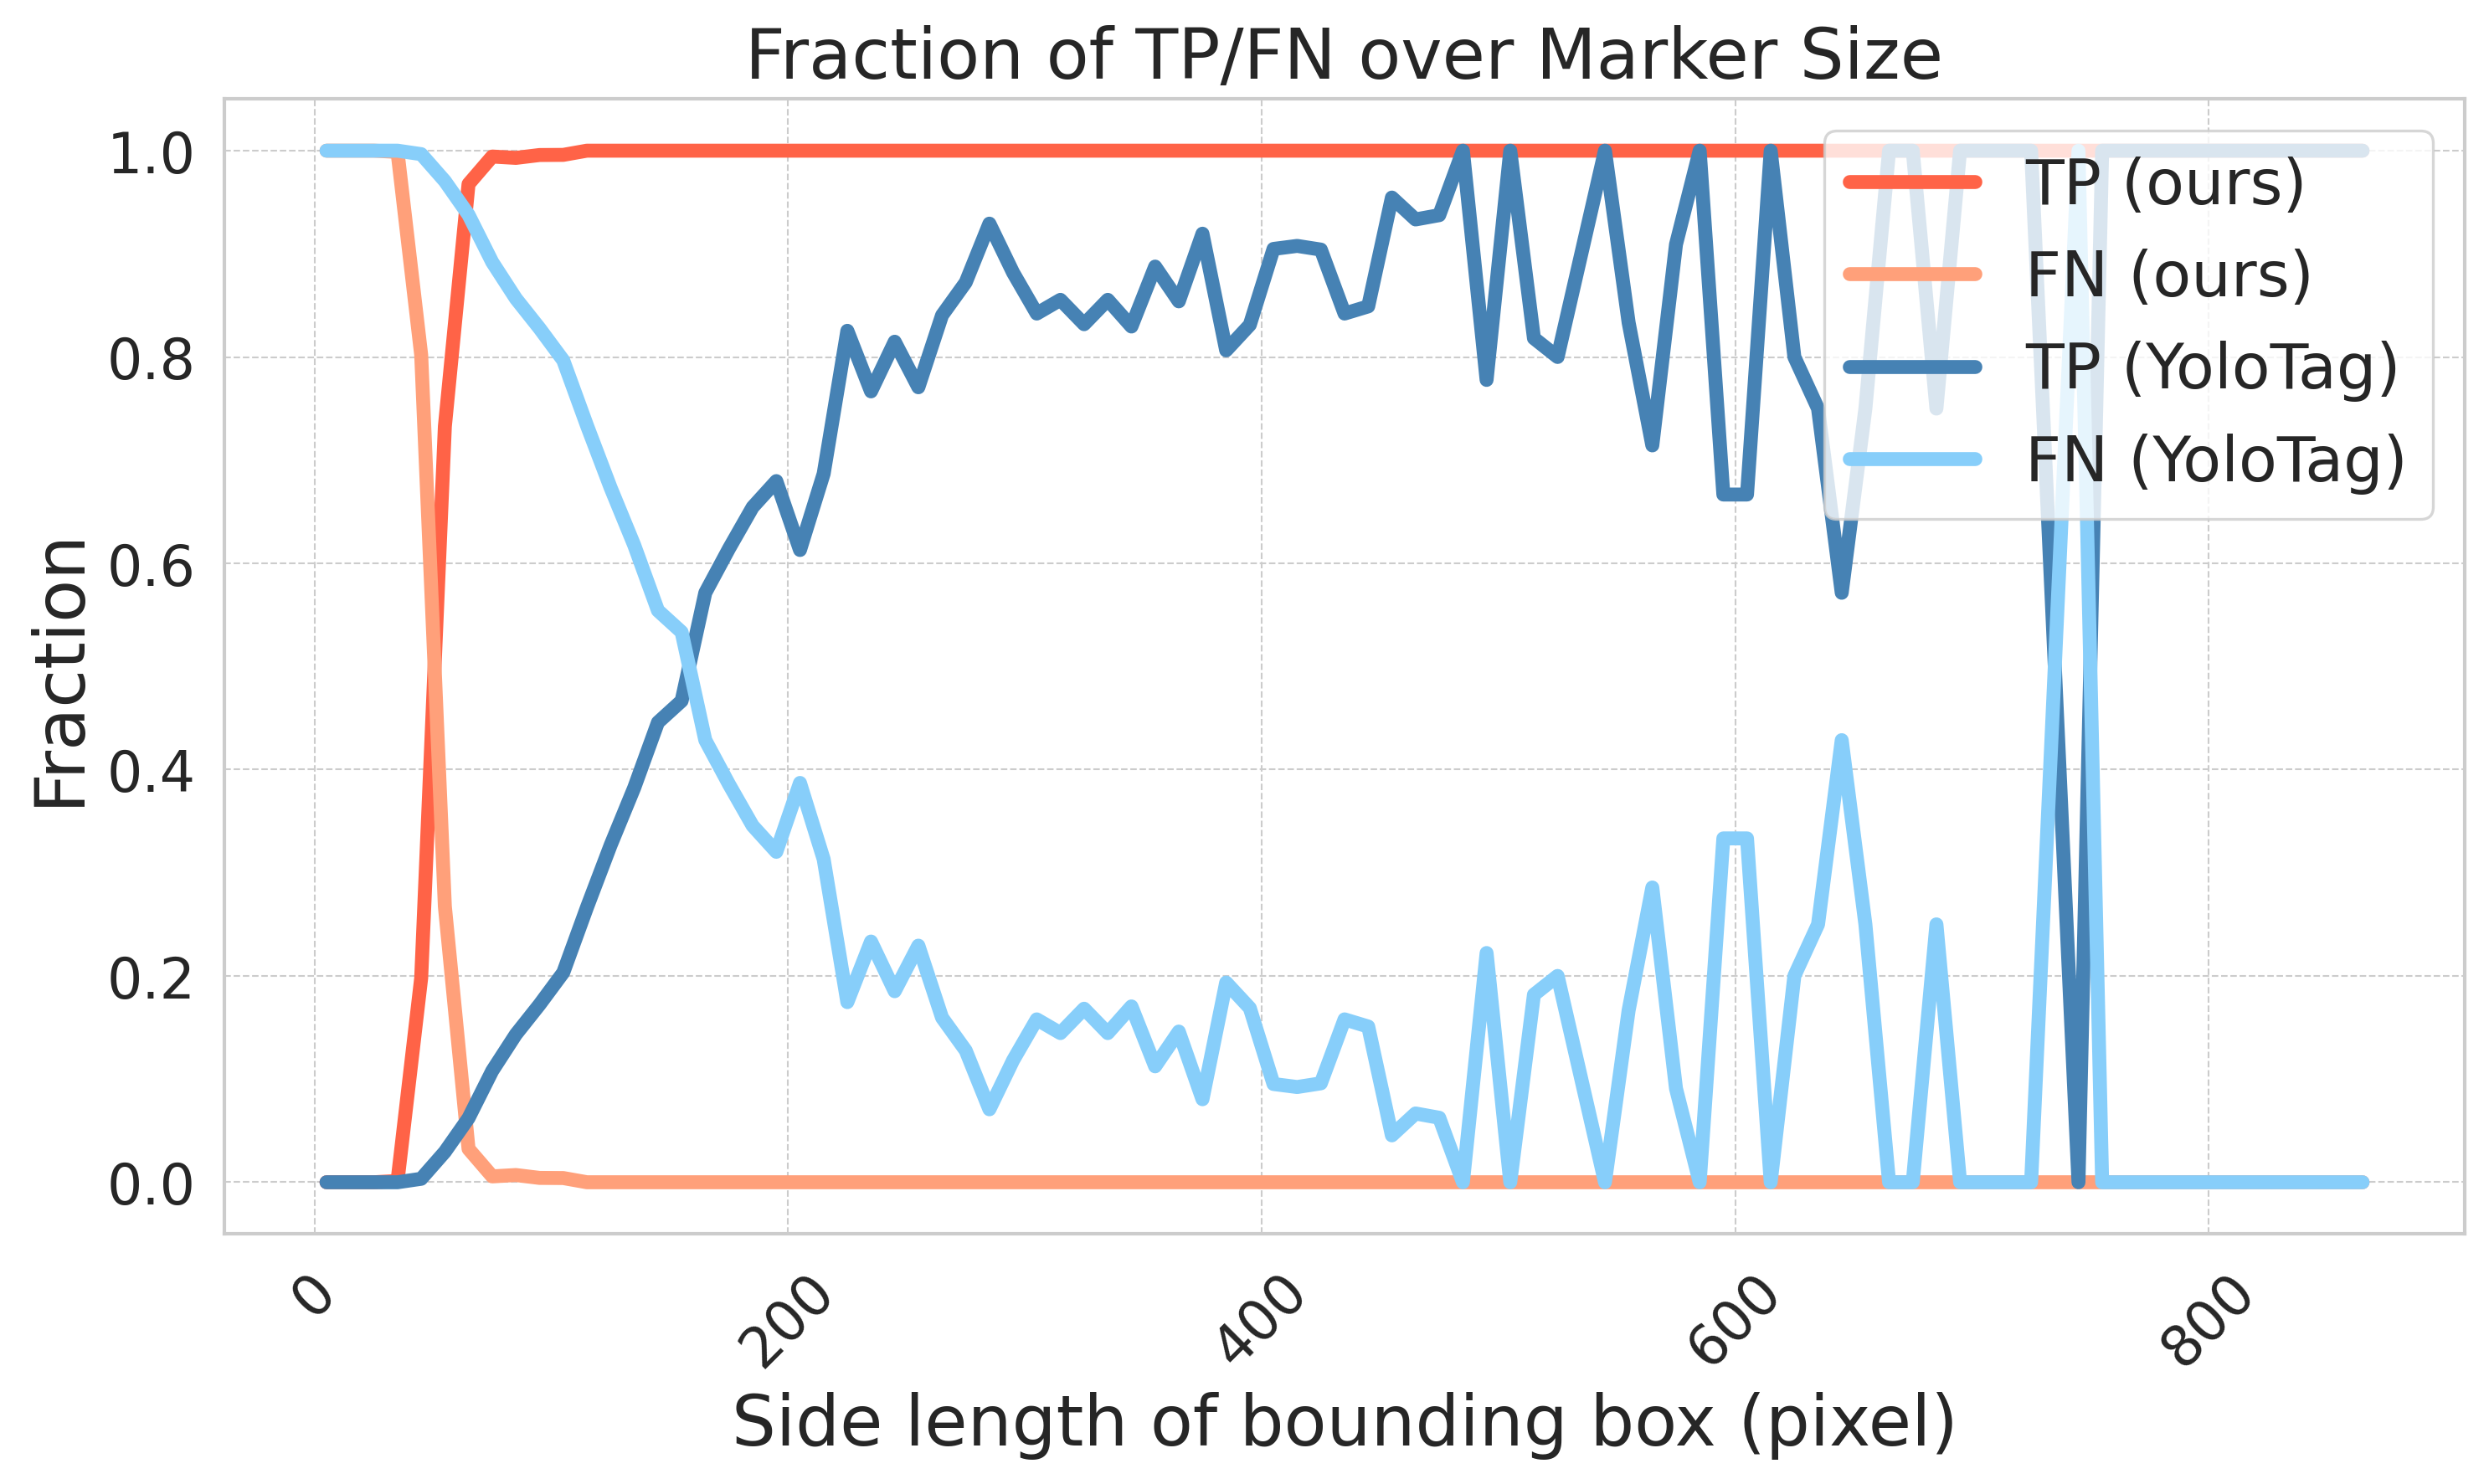

In [21]:
import seaborn as sns

sns.set_context("paper") 
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6), dpi=300)  # Higher DPI for better quality

plt.plot(bin_midpoints, agg_dfm_TP, label='TP (ours)',    color='#FF6347', linestyle='-', linewidth=4, markersize=8)
plt.plot(bin_midpoints, agg_dfm_FN, label='FN (ours)',    color='#FFA07A', linestyle='-', linewidth=4, markersize=8)
plt.plot(bin_midpoints, agg_dfy_TP, label='TP (YoloTag)', color='#4682B4', linestyle='-', linewidth=4, markersize=8)
plt.plot(bin_midpoints, agg_dfy_FN, label='FN (YoloTag)', color='#87CEFA', linestyle='-', linewidth=4, markersize=8)

# Label the axes with larger font size
plt.xlabel('Side length of bounding box (pixel)', fontsize=20)
plt.ylabel('Fraction', fontsize=20)

# Add a title with a larger font size
plt.title('Fraction of TP/FN over Marker Size', fontsize=20)

# Customize the legend
plt.legend(fontsize=18, loc='upper right', frameon=True)

# Increase the tick size and rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)

# Remove unnecessary grid lines (optional)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Save the plot as a high-resolution image if needed for publication
plt.tight_layout()  # This ensures everything fits well into the figure
# Show the plot
plt.show()


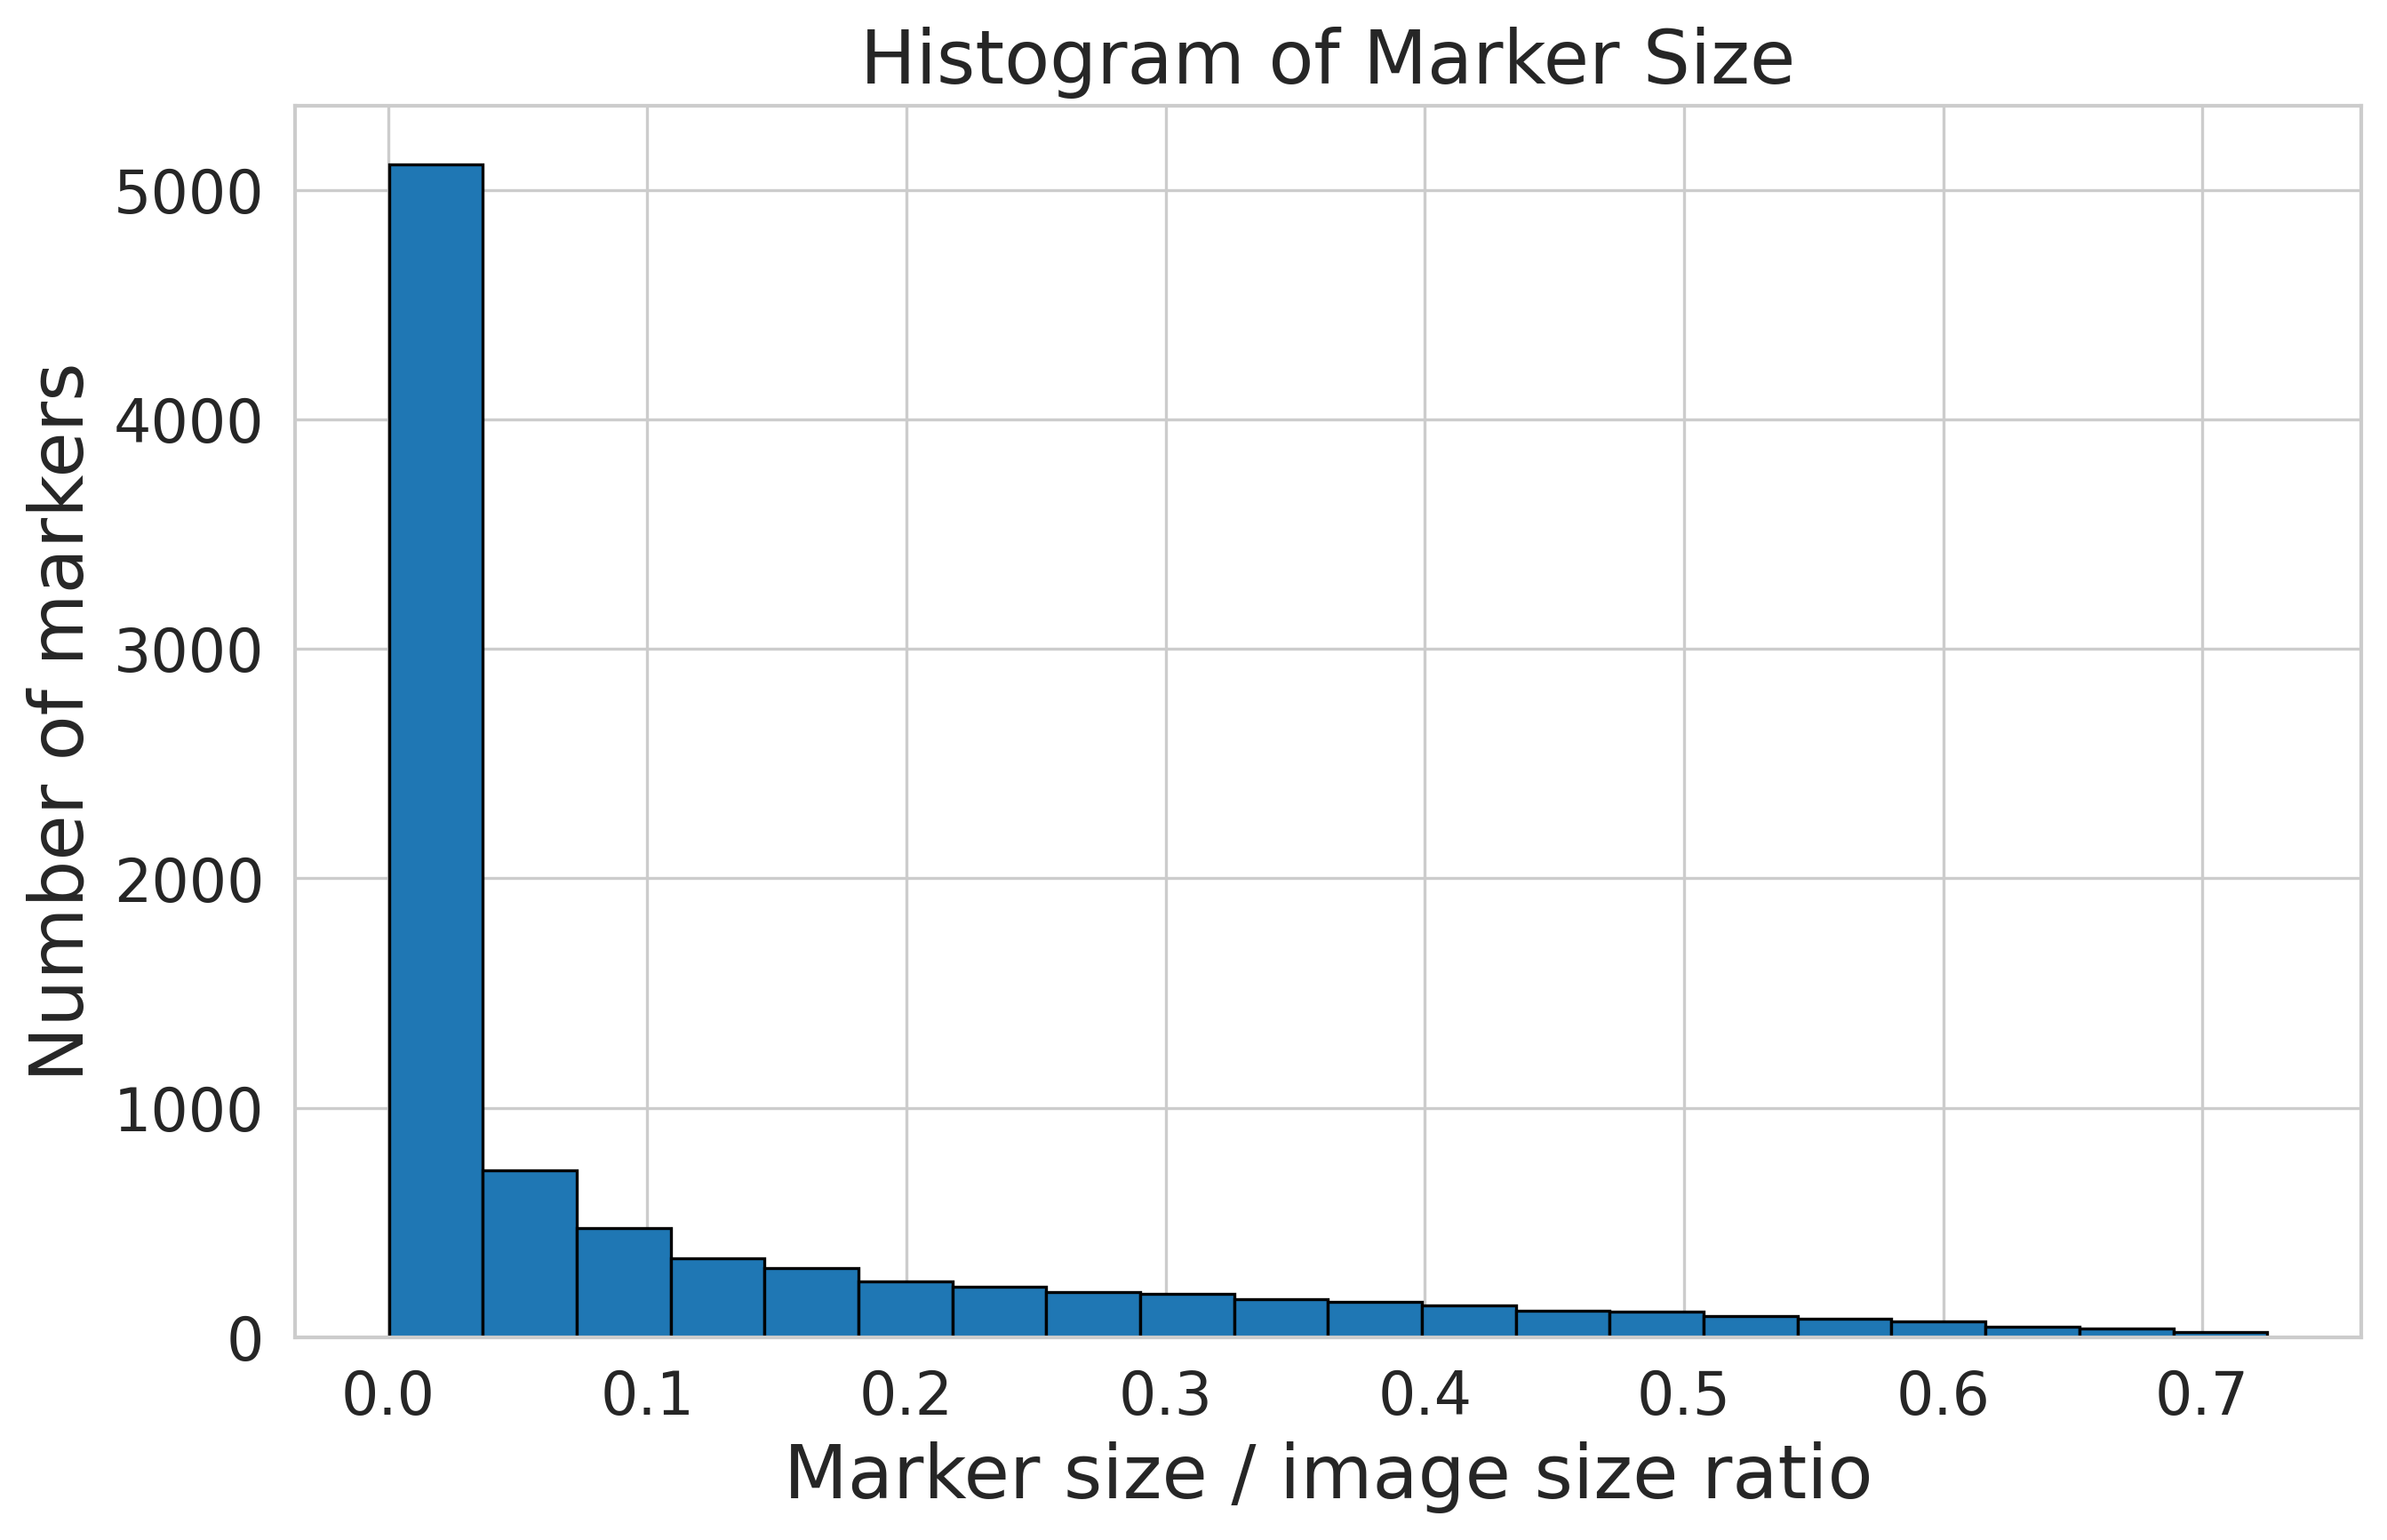

In [20]:
import matplotlib.pyplot as plt

# Filter out zeros from the 'marker_size' column
plt.figure(figsize=(10, 6), dpi=300)  # Higher DPI for better quality
filtered_data = dfm[dfm['FP'] == 0]['size_ratio']

# Create the histogram
plt.hist(filtered_data, bins=20, edgecolor='black')
plt.xlabel('Marker size / image size ratio', fontsize=20)
plt.ylabel('Number of markers', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Histogram of Marker Size', fontsize=20)
plt.show()